In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
import pickle
import math
import itertools
import torch.nn.functional as F
from tqdm import tqdm
from Bio import pairwise2

In [ ]:
# 超参数配置
KMER_LENGTH = 3  # 可调节的k-mer长度
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE = 128
D_MODEL = 128
NHEAD = 8
NUM_ENCODER_LAYERS = 3
NUM_DECODER_LAYERS = 3
CNN_OUT_CHANNELS = 64
LEARNING_RATE = 0.001
NUM_EPOCHS = 20

In [ ]:
# 生成所有可能的k-mer组合
BASES = ['A', 'T', 'C', 'G']
ALL_KMERS = [''.join(p) for p in itertools.product(BASES, repeat=KMER_LENGTH)]

# 构建k-mer词汇表
vocab = {'<sos>': 0, '<eos>': 1, '<pad>': 2}
current_idx = 3
for kmer in ALL_KMERS:
    vocab[kmer] = current_idx
    current_idx += 1
tgt_vocab_size = len(vocab)

In [116]:
# 辅助函数
def reverse_complement(s):
    complement = {'A': 'T', 'T': 'A', 'C': 'G', 'G': 'C', 'N': 'N'}
    return ''.join([complement.get(c, 'N') for c in reversed(s)])

def remove_outliers(sequences):
    result = []
    for arr in sequences:
        q1 = np.percentile(arr, 25)
        q3 = np.percentile(arr, 75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        filtered_arr = arr[(arr >= lower_bound) & (arr <= upper_bound)]
        result.append(filtered_arr)
    return result

In [117]:
# 数据加载与预处理
data_path = './data_slice/'
DNA_label = [
    'TTTTTTTTTCCTTTTTTTTTTTCCCTAAACAAGAATACCACGACTAGCATTTTTCAGATCTCACTATC',
    'AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAATTTTTTTTTTAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA',
    'TTTTTTTTTTTTTTTGGGGGTTTTTTTTTTTTTTTAAAAATTTTTTTTTTTTTTTCCCCC',
    'TTTTTTTTTTTTTTTTTTGGTTTTTTTTTTTTTTTTTTAATTTTTTTTTTTTTTTTTTTCC',
    'AAAAAAAAAAAAAAAAAAGGTTTTTTTTTTTTTTTTTTGGAAAAAAAAAAAAAAAAAACC'
]

# 加载并增强训练数据
sequences, labels = [], []
sequences_test, labels_test = [], []

for f in os.listdir(data_path):
    path = os.path.join(data_path, f)
    with open(path, 'rb') as file:
        slice_data = pickle.load(file)
        label_number = f.split('.')[0][-1]
        
        if label_number == '2':
            # 测试数据不增强
            for seq in slice_data:
                if 10 <= len(seq) <= 5000:
                    sequences_test.append(seq)
                    labels_test.append(DNA_label[int(label_number)-2])
        else:
            # 训练数据增强
            original_label = DNA_label[int(label_number)-2]
            for seq in slice_data:
                if 10 <= len(seq) <= 5000:
                    # 原始方向
                    sequences.append(seq)
                    labels.append(original_label)
                    # 反转方向
                    reversed_seq = seq[::-1].copy()
                    reversed_label = reverse_complement(original_label)
                    sequences.append(reversed_seq)
                    labels.append(reversed_label)

# 数据清洗
src_data = [seq[:MAX_SRC_LEN] for seq in remove_outliers(sequences)]
tgt_data = labels
src_data_test = [seq[:MAX_SRC_LEN] for seq in remove_outliers(sequences_test)]
tgt_data_test = labels_test

# 构建词汇表
vocab = {'<sos>': 0, '<eos>': 1, '<pad>': 2}
for seq in tgt_data + tgt_data_test:
    for c in seq:
        if c not in vocab:
            vocab[c] = len(vocab)
tgt_vocab_size = len(vocab)
max_tgt_len = max(len(seq) for seq in tgt_data) + 2

In [118]:
class TranslationDataset(Dataset):
    def __init__(self, src_data, tgt_data):
        self.src, self.tgt_input, self.tgt_output = [], [], []
        
        # 处理源数据
        for seq in src_data:
            seq = np.array(seq)
            seq_mean = np.mean(seq)
            seq_std = np.std(seq) + 1e-8
            normalized = [(x - seq_mean)/seq_std for x in seq]
            padded = normalized + [0]*(MAX_SRC_LEN - len(normalized))
            self.src.append(padded[:MAX_SRC_LEN])
        
        # 处理目标数据
        for seq in tgt_data:
            indexed = [0] + [vocab[c] for c in seq] + [1]
            input_seq = indexed[:-1] + [2]*(max_tgt_len - len(indexed) + 1)
            output_seq = indexed[1:] + [2]*(max_tgt_len - len(indexed) + 1)
            self.tgt_input.append(input_seq[:max_tgt_len])
            self.tgt_output.append(output_seq[:max_tgt_len])

    def __len__(self):
        return len(self.src)

    def __getitem__(self, idx):
        return (
            torch.tensor(self.src[idx], dtype=torch.float32),
            torch.tensor(self.tgt_input[idx], dtype=torch.long),
            torch.tensor(self.tgt_output[idx], dtype=torch.long)
        )

In [119]:
# 模型组件
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=500):
        super().__init__()
        self.dropout = nn.Dropout(p=DROPOUT)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(1))

    def forward(self, x):
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

class Seq2SeqTransformer(nn.Module):
    def __init__(self):
        super().__init__()
        # 双向卷积层
        self.dropout = nn.Dropout(0.3)
        self.conv_fwd = nn.Sequential(
            nn.Conv1d(1, 32, 5, padding=2),
            nn.BatchNorm1d(32),
            nn.GELU(),
            nn.Dropout(0.3),
            nn.Conv1d(32, D_MODEL//2, 3, padding=1)
        )
        self.conv_rev = nn.Sequential(
            nn.Conv1d(1, 32, 5, padding=2),
            nn.BatchNorm1d(32),
            nn.GELU(),
            nn.Dropout(0.3),
            nn.Conv1d(32, D_MODEL//2, 3, padding=1)
        )
        self.src_proj = nn.Linear(D_MODEL, D_MODEL)
        self.pos_encoder = PositionalEncoding(D_MODEL)
        
        self.transformer = nn.Transformer(
            d_model=D_MODEL,
            nhead=4,  # 减少注意力头数
            num_encoder_layers=2,
            num_decoder_layers=2,
            dim_feedforward=256,
            dropout=0.3
        )
        self.tgt_embed = nn.Embedding(tgt_vocab_size, D_MODEL)
        self.fc_out = nn.Linear(D_MODEL, tgt_vocab_size)
        self.init_weights()

    def init_weights(self):
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

    def forward(self, src, tgt):
        # 源序列处理
        src = src.unsqueeze(-1)  # [B, S, 1]
        src = src.permute(1, 0, 2)  # [S, B, 1]
        
        # 双向特征提取
        src_fwd = self.conv_fwd(src.permute(1, 2, 0)).permute(2, 0, 1)  # [S, B, D//2]
        src_rev = self.conv_rev(torch.flip(src, [0]).permute(1, 2, 0)).permute(2, 0, 1)  # [S, B, D//2]
        src_features = torch.cat([src_fwd, src_rev], dim=-1)  # [S, B, D]
        
        src_emb = self.dropout(self.src_proj(src_features))
        src_emb = self.pos_encoder(src_emb)
        
        # 目标序列处理
        tgt = tgt.permute(1, 0)  # [T, B]
        tgt_emb = self.dropout(self.tgt_embed(tgt) * math.sqrt(D_MODEL))
        tgt_emb = self.pos_encoder(tgt_emb)
        
        # 生成掩码
        src_padding_mask = (src.squeeze(-1) == 0).transpose(0, 1)
        tgt_padding_mask = (tgt == 2).transpose(0, 1)
        tgt_mask = nn.Transformer.generate_square_subsequent_mask(tgt.size(0)).to(device)
        
        output = self.transformer(
            src_emb, tgt_emb,
            src_key_padding_mask=src_padding_mask,
            tgt_key_padding_mask=tgt_padding_mask,
            memory_key_padding_mask=src_padding_mask,
            tgt_mask=tgt_mask
        )
        return self.fc_out(output)


In [120]:
# 初始化模型
model = Seq2SeqTransformer().to(device)
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.01)
criterion = nn.CrossEntropyLoss(ignore_index=2)
scheduler = get_linear_schedule_with_warmup(
    optimizer, 
    num_warmup_steps=10,
    num_training_steps=100
)

# 数据加载
dataset = TranslationDataset(src_data, tgt_data)
train_size = int(0.8 * len(dataset))
train_dataset, val_dataset = random_split(dataset, [train_size, len(dataset)-train_size])
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)


In [121]:
# 训练循环
best_val_loss = float('inf')
train_losses, val_losses = [], []

for epoch in range(NUM_EPOCHS):
    model.train()
    epoch_train_loss = 0
    
    for src, tgt_in, tgt_out in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        src = src.to(device)
        tgt_in = tgt_in.to(device)
        tgt_out = tgt_out.to(device).permute(1, 0)
        
        optimizer.zero_grad()
        output = model(src, tgt_in)
        loss = criterion(output.view(-1, tgt_vocab_size), tgt_out.reshape(-1))
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        
        epoch_train_loss += loss.item()
    
    avg_train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # 验证
    model.eval()
    epoch_val_loss = 0
    with torch.no_grad():
        for src, tgt_in, tgt_out in val_loader:
            src = src.to(device)
            tgt_in = tgt_in.to(device)
            tgt_out = tgt_out.to(device).permute(1, 0)
            
            output = model(src, tgt_in)
            loss = criterion(output.view(-1, tgt_vocab_size), tgt_out.reshape(-1))
            epoch_val_loss += loss.item()
    
    avg_val_loss = epoch_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    
    # 保存最佳模型
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"Saved best model with val loss {avg_val_loss:.4f}")
    
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}")
    print(f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")
    print('-'*50)


Epoch 1: 100%|██████████| 426/426 [00:45<00:00,  9.42it/s]


Saved best model with val loss 0.3842
Epoch 1/20
Train Loss: 0.4353 | Val Loss: 0.3842
--------------------------------------------------


Epoch 2: 100%|██████████| 426/426 [00:44<00:00,  9.49it/s]


Epoch 2/20
Train Loss: 0.3874 | Val Loss: 0.3842
--------------------------------------------------


Epoch 3: 100%|██████████| 426/426 [00:44<00:00,  9.51it/s]


Epoch 3/20
Train Loss: 0.3876 | Val Loss: 0.3842
--------------------------------------------------


Epoch 4:   9%|▉         | 39/426 [00:04<00:40,  9.46it/s]


KeyboardInterrupt: 

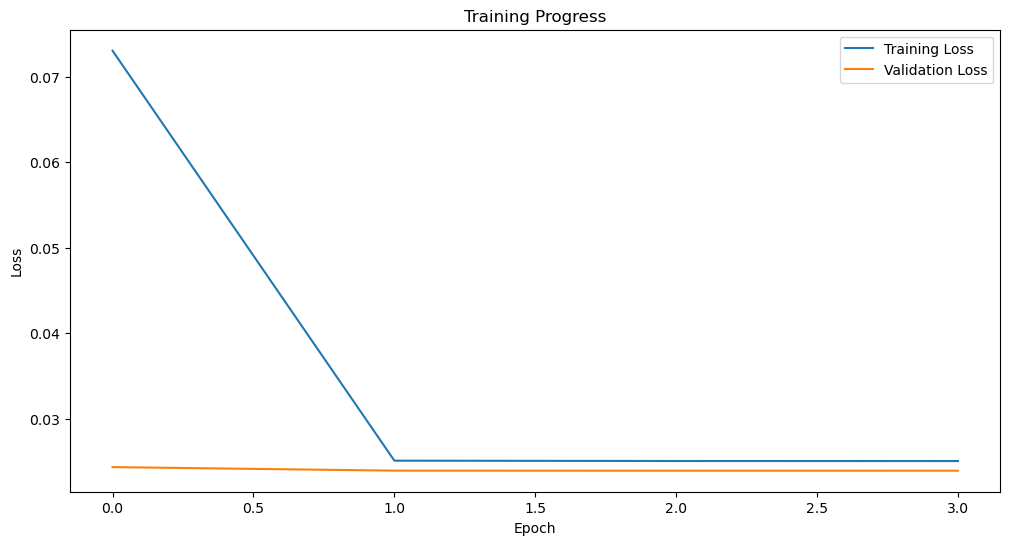

In [ ]:
# 可视化训练过程
plt.figure(figsize=(12,6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training Progress')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('training_curve.png')

In [122]:
# 推理函数
def preprocess_input(seq):
    seq = np.array(seq[:MAX_SRC_LEN])
    seq_mean = np.mean(seq)
    seq_std = np.std(seq) + 1e-8
    normalized = [(x - seq_mean)/seq_std for x in seq]
    padded = normalized + [0]*(MAX_SRC_LEN - len(normalized))
    return torch.tensor(padded, dtype=torch.float32).unsqueeze(0).to(device)

def translate_once(model, src_seq, max_length=200):
    src_tensor = preprocess_input(src_seq)
    tgt_tokens = [vocab['<sos>']]
    total_prob = 0.0
    
    for _ in range(max_length):
        tgt_tensor = torch.tensor(tgt_tokens, dtype=torch.long).unsqueeze(0).to(device)
        with torch.no_grad():
            output = model(src_tensor, tgt_tensor)
        
        probs = F.softmax(output[-1], dim=-1)
        next_token = probs.argmax().item()
        total_prob += probs.max().item()
        
        if next_token == vocab['<eos>']:
            break
        tgt_tokens.append(next_token)
    
    idx_to_char = {v:k for k,v in vocab.items()}
    decoded = [idx_to_char[idx] for idx in tgt_tokens[1:]]
    return ''.join(decoded), total_prob/len(tgt_tokens)

def full_translate(model, src_seq, max_length=200):
    pred_fwd, prob_fwd = translate_once(model, src_seq, max_length)
    pred_rev, prob_rev = translate_once(model, src_seq[::-1], max_length)
    return pred_fwd if prob_fwd >= prob_rev else reverse_complement(pred_rev)

# 加载最佳模型
model.load_state_dict(torch.load('best_model.pth', map_location=device))
model.eval()


/tmp/ipykernel_613597/393175432.py:38: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth', map_location=device))


Seq2SeqTransformer(
  (dropout): Dropout(p=0.3, inplace=False)
  (conv_fwd): Sequential(
    (0): Conv1d(1, 32, kernel_size=(5,), stride=(1,), padding=(2,))
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): GELU(approximate='none')
    (3): Dropout(p=0.3, inplace=False)
    (4): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  )
  (conv_rev): Sequential(
    (0): Conv1d(1, 32, kernel_size=(5,), stride=(1,), padding=(2,))
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): GELU(approximate='none')
    (3): Dropout(p=0.3, inplace=False)
    (4): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  )
  (src_proj): Linear(in_features=128, out_features=128, bias=True)
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.3, inplace=False)
  )
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-1): 2 x TransformerEnc

In [123]:
# 评估函数
def evaluate(model, test_src, test_tgt, num_samples=100):
    indices = np.random.choice(len(test_src), min(num_samples, len(test_src)), replace=False)
    total_similarity = 0.0
    
    for idx in tqdm(indices, desc="Evaluating"):
        src_seq = test_src[idx]
        true_label = test_tgt[idx]
        
        # 双向预测
        pred_seq = full_translate(model, src_seq)
        
        # 序列比对
        alignments = pairwise2.align.globalms(
            true_label, pred_seq, 1, 0, -0.1, -0.1
        )
        
        if alignments:
            best_aln = alignments[0]
            matches = sum(a == b for a,b in zip(best_aln.seqA, best_aln.seqB))
            similarity = matches / len(true_label) * 100
            total_similarity += similarity
    
    return total_similarity / len(indices)

# 运行评估
test_score = evaluate(model, src_data_test, tgt_data_test)
print(f"\nAverage Similarity on Test Set: {test_score:.2f}%")

Evaluating: 100%|██████████| 100/100 [02:05<00:00,  1.25s/it]


Average Similarity on Test Set: 15.06%


In [131]:
# 测试样例
import random
rd = random.randint(0, len(src_data_test)-1)
sample = src_data_test[rd]
label = tgt_data_test[rd]
# 使用模型进行翻译 
translated = full_translate(model, sample)
# 全局比对（Needleman-Wunsch算法，匹配=1，不匹配/gap=0）
alignments = pairwise2.align.globalms(
    label, translated, 1, 0, -0.1, -0.1
)

if alignments:
    best_alignment = alignments[0]
    aligned_label = best_alignment.seqA  
    aligned_pred = best_alignment.seqB   
    matches = sum(a == b for a, b in zip(aligned_label, aligned_pred))
    label_len = len(label)  # 原始标签长度
    similarity = (matches / label_len) * 100 if label_len > 0 else 0
print(f'Translated: {translated}')
print(f'Original: {label}')
print(f'Similarity: {similarity:.2f}%')

Translated: GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG
Original: TTTTTTTTTCCTTTTTTTTTTTCCCTAAACAAGAATACCACGACTAGCATTTTTCAGATCTCACTATC
Similarity: 5.88%
